# Auto ML

In [2]:
import pandas as pd
from autogluon.tabular import TabularDataset, TabularPredictor
import utils.eda_utils as eda_utils 
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_error, r2_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler

d:\rockhead_prediction\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\rockhead_prediction\.venv\Lib\site-packages\spaghetti\network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


## Data Load

## columns info

|column name|Description|test input|
|---|---|---|
|borehole_code|시추공 코드|X|
|x|위도|O|
|y|경도|O|
|depth_start|rockhead 시작 심도|output|
|Ground name|지반명- 0: 풍화암, 1: 연암, 2: 보통암, 4: 경암|O|
|Slope|경사|O|
|Aspect|경사방향|O|
|DEM|DEM|O|
|Rock Type|지질도에 따른 rock type|O|
|dis_bin|radius count에 따라 총 구간을 30개로 나눈 group|X|

* Rock type: {0:화성암, 1:퇴적암, 2:변성암}
* dis_bin: radius count 그룹에 따라 evaluation 하기 위한 값

In [8]:
train_df = pd.read_csv('data/241121_Rockhead_Seoul_train(before_aumentation).csv')
test_df = pd.read_csv('data/241121_Rockhead_Seoul_test(before_aumentation).csv')

C:\Users\user\AppData\Local\Temp\ipykernel_36288\2731312767.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_concat = pd.concat([df_concat, train_df_copy, test_df_copy])


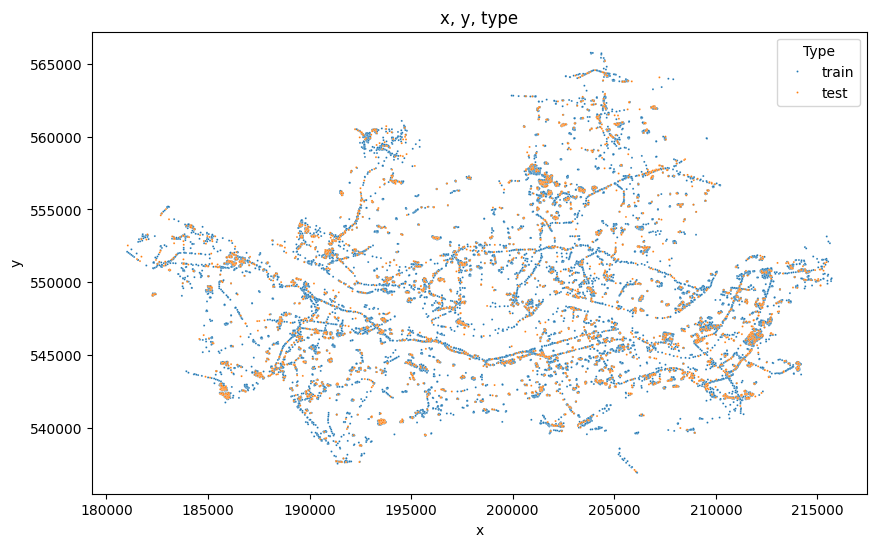

In [9]:
train_df_copy = train_df.copy()
test_df_copy = test_df.copy()


train_df_copy['Type'] = 'train'
test_df_copy['Type'] = 'test'

df_concat = pd.DataFrame(columns=train_df_copy.columns)
df_concat = pd.concat([df_concat, train_df_copy, test_df_copy])

eda_utils.scatter_relation(df_concat, 'x', 'y', 2, 'x, y, type','Type')

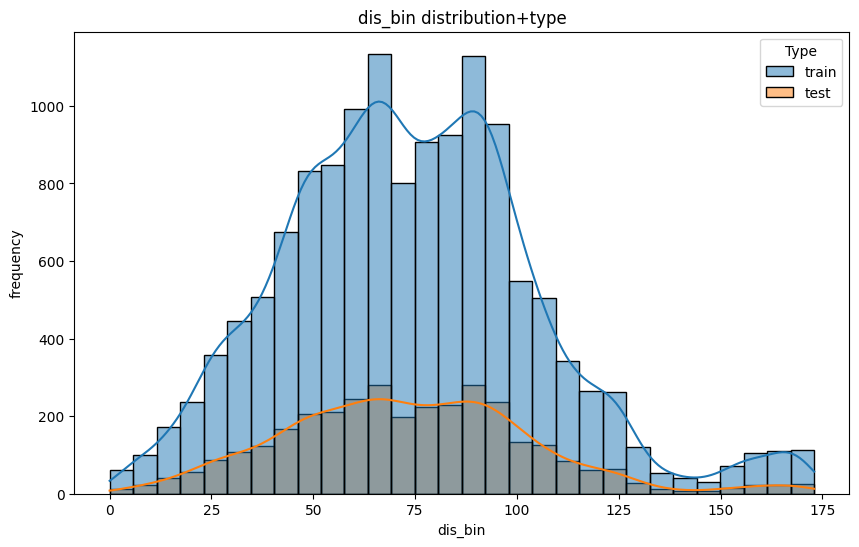

In [10]:
eda_utils.distribution_histogram(df_concat, 'dis_bin', 'dis_bin distribution+type', 'Type')

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16245 entries, 0 to 16244
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   x            16245 non-null  float64
 1   y            16245 non-null  float64
 2   depth_start  16245 non-null  float64
 3   slope        16245 non-null  float64
 4   aspect       16245 non-null  float64
 5   DEM          16245 non-null  float64
 6   rock_type_1  16245 non-null  bool   
 7   rock_type_2  16245 non-null  bool   
 8   dis_bin      16245 non-null  float64
dtypes: bool(2), float64(7)
memory usage: 920.3 KB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4061 entries, 0 to 4060
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   x            4061 non-null   float64
 1   y            4061 non-null   float64
 2   depth_start  4061 non-null   float64
 3   slope        4061 non-null   float64
 4   aspect       4061 non-null   float64
 5   DEM          4061 non-null   float64
 6   rock_type_1  4061 non-null   bool   
 7   rock_type_2  4061 non-null   bool   
 8   dis_bin      4061 non-null   float64
dtypes: bool(2), float64(7)
memory usage: 230.1 KB


## Pre-Processing

In [11]:
# Min Max Scaling: x, y, slope, DEM
column_to_scale = ['x', 'y', 'slope', 'aspect', 'DEM']

scaler = MinMaxScaler()

# train_dataset
train_df[column_to_scale] = scaler.fit_transform(train_df[column_to_scale])
train_df['depth_start'] = train_df['depth_start']

# test_dataset
test_df[column_to_scale] = scaler.fit_transform(test_df[column_to_scale])
test_df['depth_start'] = test_df['depth_start']

display(train_df.describe())
display(test_df.describe())

,x,y,depth_start,slope,aspect,DEM,dis_bin
count,16245.000000,16245.000000,16245.000000,16245.000000,16245.000000,16245.000000,16245.000000
mean,0.534525,0.422278,10.742811,0.523593,0.501207,0.081943,9.950262
std,0.233821,0.187289,7.277804,0.054620,0.290767,0.074098,5.451414
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.336490,0.272908,5.000000,0.505552,0.246993,0.036048,6.000000
50%,0.581727,0.404623,9.900000,0.528247,0.510957,0.057436,9.000000
75%,0.703134,0.532169,15.600000,0.542125,0.756616,0.101762,13.000000
max,1.000000,1.000000,64.500000,1.000000,1.000000,1.000000,29.000000


,x,y,depth_start,slope,aspect,DEM,dis_bin
count,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000,4061.000000
mean,0.535506,0.413595,10.725260,0.548705,0.505752,0.130934,9.924403
std,0.236515,0.187184,7.116045,0.057255,0.290306,0.113909,5.425669
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.333530,0.262296,5.100000,0.531085,0.252633,0.058306,6.000000
50%,0.584082,0.402635,10.000000,0.553969,0.524646,0.091307,9.000000
75%,0.707542,0.526315,15.500000,0.568651,0.761617,0.161654,13.000000
max,1.000000,1.000000,56.500000,1.000000,1.000000,1.000000,29.000000


C:\Users\user\AppData\Local\Temp\ipykernel_18496\2444262702.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_concat = pd.concat([df_concat, train_df, test_df])


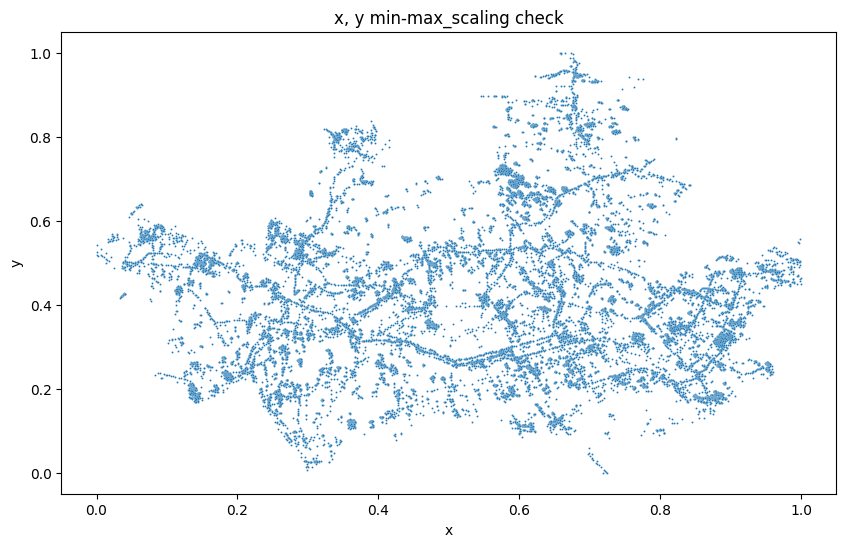

In [12]:
df_concat = pd.DataFrame(columns=train_df.columns)
df_concat = pd.concat([df_concat, train_df, test_df])
eda_utils.scatter_relation(df_concat, 'x', 'y', 2, 'x, y min-max_scaling check')

In [13]:
train = TabularDataset(train_df.drop(['dis_bin'], axis=1))
test = TabularDataset(test_df.drop(['dis_bin'], axis=1))
X_test = TabularDataset(test_df.drop(['depth_start', 'dis_bin'], axis=1))
y_test = test_df['depth_start'].values.tolist()

## Training-Validation

In [14]:
predictor = TabularPredictor(label='depth_start', 
                             problem_type = 'regression', 
                             eval_metric='r2',
                             verbosity =2 
                             )

predictor.fit(train,
              num_gpus=1,
              time_limit = 3600*24, 
              presets="best_quality", 
              save_space = True, 
              keep_only_best = True,
              save_bag_folds = True,
              ag_args_fit = {'num_gpus': 1} # Train with GPU, # 140 models without gpu, 84 models with gpu during 3600*10(241026), 120 models with gpu during 3600*14(241028)
              )

No path specified. Models will be saved in: "AutogluonModels\ag-20241113_073506"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          16
Memory Avail:       19.23 GB / 31.93 GB (60.2%)
Disk Space Avail:   575.02 GB / 931.51 GB (61.7%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the data. Then holdo

In [15]:
ld_board = predictor.leaderboard(test, silent=True)

ld_board

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,KNeighborsDist_BAG_L1,0.576036,0.711311,r2,0.094911,0.094518,0.035506,0.094911,0.094518,0.035506,1,True,2
1,KNeighborsUnif_BAG_L1,0.571068,0.667409,r2,0.082492,0.074081,0.051518,0.082492,0.074081,0.051518,1,True,1
2,ExtraTrees_r49_BAG_L1,0.481314,0.758826,r2,2.394392,0.535094,0.888658,2.394392,0.535094,0.888658,1,True,54
3,XGBoost_r98_BAG_L1,0.480137,0.745965,r2,6.427258,1.868768,444.490281,6.427258,1.868768,444.490281,1,True,47
4,LightGBM_r121_BAG_L1,0.476933,0.753757,r2,2.171386,2.555453,842.184119,2.171386,2.555453,842.184119,1,True,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,NeuralNetTorch_r185_BAG_L1,0.306093,0.657613,r2,0.510091,0.095517,529.626082,0.510091,0.095517,529.626082,1,True,76
111,NeuralNetTorch_r89_BAG_L1,0.305942,0.617243,r2,0.345175,0.093013,443.878717,0.345175,0.093013,443.878717,1,True,108
112,NeuralNetTorch_r36_BAG_L1,0.296994,0.546043,r2,0.282051,0.090013,393.415435,0.282051,0.090013,393.415435,1,True,98
113,NeuralNetTorch_r22_BAG_L1,0.294602,0.670353,r2,0.647125,0.081511,490.080850,0.647125,0.081511,490.080850,1,True,18


## Prediction

In [16]:
pred_y = predictor.predict(X_test, ld_board.model[1])

In [17]:
mae = mean_absolute_error(y_test, pred_y)
mse = mean_squared_error(y_test, pred_y)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred_y)

print('mae: ',mae)
print('mse: ',mse)
print('rmse: ',rmse)
print('r2: ',r2) #1에 가까울수록 좋음

mae:  3.335306577629583
mse:  21.714925220458227
rmse:  4.659927598199164
r2:  0.5710684778681563
